***Google Colab -> Cette cellule est à executer (2 fois) pour le cloner le dépot en local***  
il est possible que google colab vous demande re demarrer la session

In [2]:
!git clone https://github.com/ManDes71/Rakuten_Text_Classification_ML.git

Cloning into 'Rakuten_Text_Classification_ML'...
remote: Enumerating objects: 315, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 315 (delta 55), reused 16 (delta 5), pack-reused 208
Receiving objects: 100% (315/315), 52.00 MiB | 7.32 MiB/s, done.
Resolving deltas: 100% (146/146), done.
Updating files: 100% (56/56), done.
Filtering content: 100% (5/5), 1.41 GiB | 43.60 MiB/s, done.


***Google Colab -> Cette cellule est à executer (2 fois) pour installer les bibliothèques nécessaires***  
You must restart the runtime in order to use newly installed versions.  

In [1]:
import sys
sys.path.append('/content/Rakuten_Text_Classification_ML')
import sys
print(sys.version)

!pip install -r /content/Rakuten_Text_Classification_ML/requirements.txt

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


# ***PROJET RAKUTEN***  

## **1) Description du projet**  
**Description du problème**    

1.   Élément de liste
2.   Élément de liste


L'objectif de ce défi est la classification à grande échelle des données de produits multimodales (texte et image) en type de produit.  
Par exemple, dans le catalogue de Rakuten France, un produit avec une désignation "Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style" associé à une image (image_938777978_product_201115110.jpg) et
parfois à une description supplémentaire. Ce produit est catégorisé sous le code de produit 50.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
pd.set_option('display.max_colwidth', 150)

In [5]:
# lecture des données sources d'entrainement
df_feats=pd.read_csv('/content/Rakuten_Text_Classification_ML/X_train_update.csv')

# lecture des données cibles d'entrainement
df_target=pd.read_csv('/content/Rakuten_Text_Classification_ML/Y_train_CVw08PX.csv')

# création d'un dataframe globale -  jointure
df=df_feats.merge(df_target,on='Unnamed: 0',how='inner')
df.rename(columns={'Unnamed: 0': 'Id'}, inplace=True)

In [ ]:
df.head()

,Id,designation,description,productid,imageid,prdtypecode
0,0,Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design,NaN,3804725264,1263597046,10
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris - Jacques Barrere - Francois Perrier - La Reforme D...,NaN,436067568,1008141237,2280
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style,PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U.<br> Pour un confort optimal et une précision maxim...,201115110,938777978,50
3,3,Peluche Donald - Europe - Disneyland 2000 (Marionnette À Doigt),NaN,50418756,457047496,1280
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut organiser un jeu de guerre de boules de neige et s'arranger pour en &ecirc;tre le vainqueur incontest&...,278535884,1077757786,2705


IMAGE  2
Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style
image_938777978_product_201115110.jpg
IMAGE  3
Peluche Donald - Europe - Disneyland 2000 (Marionnette À Doigt)
image_457047496_product_50418756.jpg
IMAGE  4
La Guerre Des Tuques
image_1077757786_product_278535884.jpg


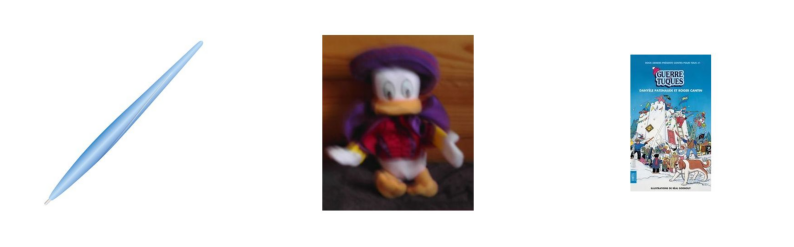

In [30]:
import os
import cv2
import matplotlib.pyplot as plt

folder_path = '/content/Rakuten_Text_Classification_ML/images/image_test'


plt.figure(figsize=(10, 10))

for i in range(2, 5):
    filename = 'image_' + str(df.iloc[i, 4]) + "_product_" + str(df.iloc[i, 3]) + ".jpg"
    designation = df.iloc[i, 1]
    print("IMAGE ",i)
    print(designation)
    print(filename)
    img = cv2.imread(os.path.join(folder_path, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR en RGB
    plt.subplot(1, 3, i-1)
    plt.imshow(img)
    #
    plt.axis('off')

plt.show()


Ce notebook fait partie d'un ensemble de sous-projets dont le resultat représente le **projet Rakuten** que j'ai réalisé pour mon diplôme de data Scientist chez Datascientest.com.  
Ce projet consiste en la classification à grande échelle des données de         produits multimodales (texte et image) en type de produits.  
Ce repositery est la partie **Machine Learning** et ne traite que de la partie texte.   
Il utilise néanmoins la bibliothèque **Bibli_DataScience** commune à l'ensemble du projet.  
D'autres dépots viendront, à savoir  :


*   La partie image  traitée par des réseaux convolutifs
*   La partie texte  traitée par des réseaux récurrents
*   Une quatrième partie qui est une syntèse que j'ai présenté par l'outils Streamlit



Il existe d'autres produits avec des titres différents, des images
différentes et éventuellement des descriptions, qui appartiennent au même code
de produit.  
En utilisant ces informations sur les produits, ce
défi propose de modéliser un classificateur pour classer les produits dans leur code de produit correspondant.  

## **2) Introduction**   

**description des fichiers**

le but du projet est de prédire le code de type de chaque produit tel que défini dans le catalogue de Rakuten France.  
La catégorisation des annonces de produits se fait par le biais de la désignation, de la description (quand elle est présente) et des images.  
Les fichiers de données sont distribués ainsi :  
***X_train_update.csv*** : fichier d'entrée d'entraînement  
***Y_train_CVw08PX.csv*** : fichier de sortie d'entraînement  
***X_test_update.csv*** : fichier d'entrée de test  
Un fichier images.zip est également fourni, contenant toutes les images.  
La décompression de ce fichier fournira un dossier nommé "images" avec deux sous-dossiers nommés ***"image_train"*** et ***"image_test"***, contenant respectivement les images d'entraînement et de test.  
Pour notre part, ne participant pas au challenge Rakuten, je n'ai pas pas accès au fichier de sortie de test.  
Le fichier d’entrée de test est donc inutilisable.  
**X_train_update.csv** : fichier d'entrée d'entraînement :  
La première ligne des fichiers d'entrée contient l'en-tête et les colonnes sont séparées par des virgules (",").  
Les colonnes sont les suivantes :  


*   **Un identifiant entier pour le produit**. Cet identifiant est utilisé pour associer le produit à son code de type de produit correspondant.
*   **Désignation** - Le titre du produit, un court texte résumant le produit
*   **Description** - Un texte plus détaillé décrivant le produit. Tous les marchands n'utilisent pas ce champ, il se peut donc que le champ de description contienne la valeur NaN pour de nombreux produits, afin de conserver l'originalité des données.
*   **productid** - Un identifiant unique pour le produit.
*   **imageid** - Un identifiant unique pour l'image associée au produit.
Les champs imageid et productid sont utilisés pour récupérer les images dans le dossier
d'images correspondant. Pour un produit donné, le nom du fichier image est :
image_imageid_product_productid.jpg ex : image_1263597046_product_3804725264.jpg  

**Y_train_CVw08PX.csv** : fichier de sortie d'entraînement :  
La première ligne des fichiers d'entrée contient l'en-tête et les colonnes sont séparées par des virgules (",").  
Les colonnes sont les suivantes :  
*  **Un identifiant entier pour le produit**. Cet identifiant est utilisé pour associer le produit à son
code de type de produit correspondant.
*  **prdtypecode** – Catégorie dans laquelle le produit est classé.

La liaison entre les fichiers se fait par une jointure sur l’identifiant entier présent les deux
fichiers.

## ***3) exploration du dataset.***  
Examinons la répartition  des codes produits :

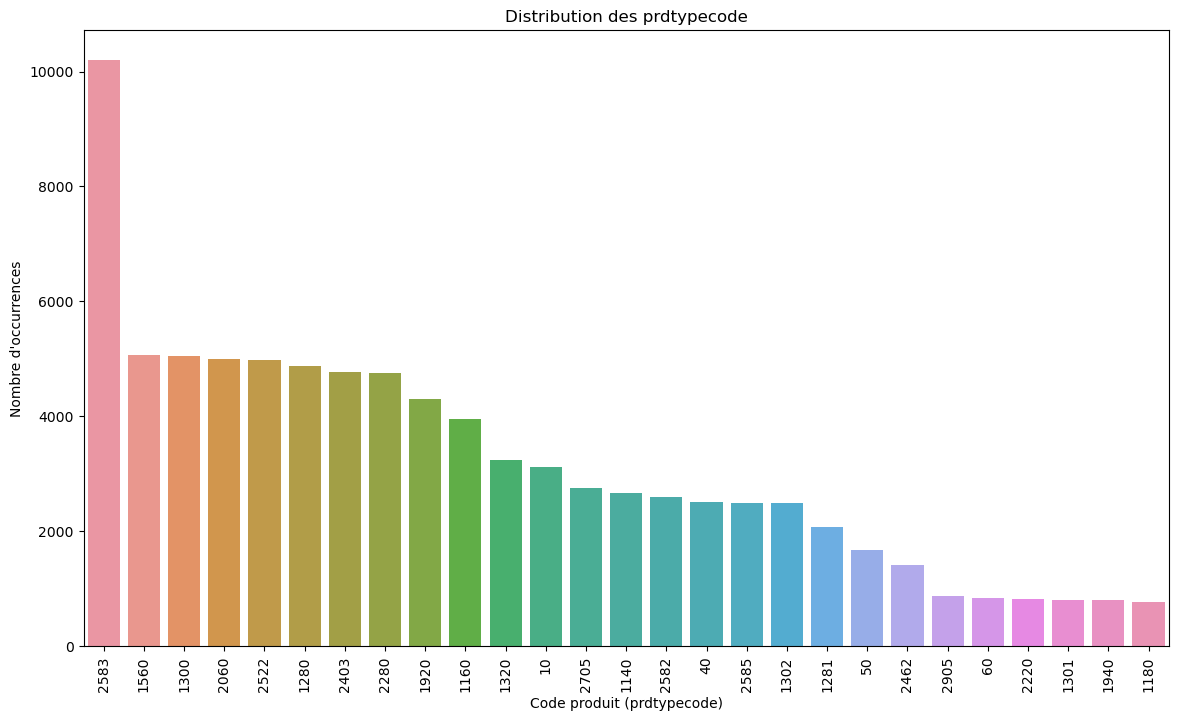

il y a une grande disparité dans la répartition des classes !


In [ ]:
cat=df_target['prdtypecode'].unique()

plt.figure(figsize=(14, 8))
sns.countplot(data=df_target, x='prdtypecode', order = df_target['prdtypecode'].value_counts().index)
plt.xticks(rotation=90)  # Rotation des labels de l'axe x pour une meilleure lisibilité
plt.title("Distribution des prdtypecode")
plt.xlabel("Code produit (prdtypecode)")
plt.ylabel("Nombre d'occurrences")
plt.show()

print("il y a une grande disparité dans la répartition des classes !")


# Proposition de nomenclature des classes ("prdtypecode")

In [ ]:
nomenclature=pd.read_csv('NOMENCLATURE.csv',header=0,encoding='utf-8',sep=';',index_col=0)
catdict=nomenclature.to_dict()['definition']
catdict

{10: 'livres',
 40: 'jeux video pour pc et consoles',
 50: ' accesoires jeux video',
 60: 'consoles de jeux video',
 1140: 'produits derives “geeks” et figurines',
 1160: 'cartes collectionables',
 1180: 'figurines collectionables pour jeux de societe',
 1280: 'jouets, peluches, puppets',
 1281: 'jeux de societe/cartes',
 1300: 'Petites voitures (jouets) et maquettes',
 1301: 'accesoires pour petis enfants/bebes et mobilier de jeu (flechettes, billard, babyfoot)',
 1302: "jeux d'exterieur",
 1320: 'sacs pour femmes et accesore petite enfance',
 1560: 'Mobilier et produits decoration/rangement pour la maison',
 1920: 'linge de maison (cousins, rideaux, serviettes, nappes, draps)',
 1940: 'nouriture (cafes,infusions,conserves, epices,etc)',
 2060: 'lampes et accesoires decoration pour maison',
 2220: 'accesoires mascots/pets',
 2280: 'magazines',
 2403: 'livres et bds',
 2462: 'consoles de jeux video et jeux videos',
 2522: 'produits de papeterie et rangement bureau',
 2582: "mobilier d'

## Comparons les champs 'designation' et 'descriptions' :

In [33]:
print("----df_feats info-------")
print(df_feats.info())
print("-"*50)
print("Le champ description n'est pas toujours présent.")
print("-"*50)
# Calcul de la moyenne des longueurs pour chaque colonne séparément
moyenne_designation = df_feats['designation'].str.len().mean()
moyenne_description = df_feats['description'].str.len().mean()

print("Moyenne de la longueur des designations:", moyenne_designation)
print("Moyenne de la longueur des descriptions:", moyenne_description)


----df_feats info-------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   84916 non-null  int64 
 1   designation  84916 non-null  object
 2   description  55116 non-null  object
 3   productid    84916 non-null  int64 
 4   imageid      84916 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.2+ MB
None
--------------------------------------------------
Le champ description n'est pas toujours présent.
--------------------------------------------------
Moyenne de la longueur des designations: 70.16330255782185
Moyenne de la longueur des descriptions: 808.1716924305102


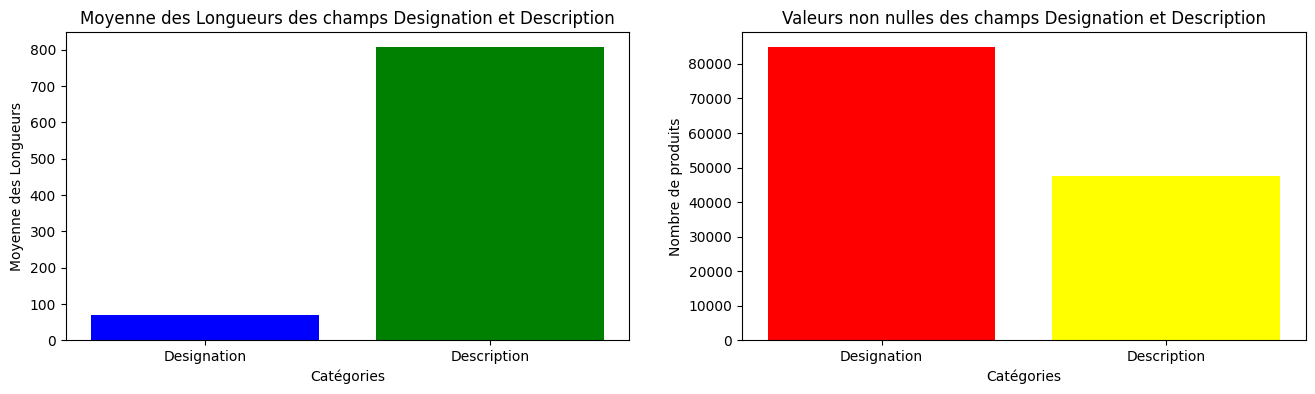

In [57]:
import matplotlib.pyplot as plt

categories = ['Designation', 'Description']

moyennes = [moyenne_designation, moyenne_description]

plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.bar(categories, moyennes, color=['blue', 'green'])
plt.title('Moyenne des Longueurs des champs Designation et Description')
plt.xlabel('Catégories')
plt.ylabel('Moyenne des Longueurs')
plt.xticks(categories)

nb_designation = len(df_feats[~df_feats['designation'].isna()])
nb_description = len(df_feats['description'].unique())  # Assurez-vous que c'est bien 'description'

Nb = [nb_designation, nb_description]
plt.subplot(1, 2, 2)
plt.bar(categories, Nb, color=['red', 'yellow'])  # Choisir des couleurs différentes
plt.title('Valeurs non nulles des champs Designation et Description')
plt.xlabel('Catégories')
plt.ylabel('Nombre de produits')
plt.xticks(categories)

plt.show()


## Examinons les valeurs nulles et les doublons du champ 'designation':

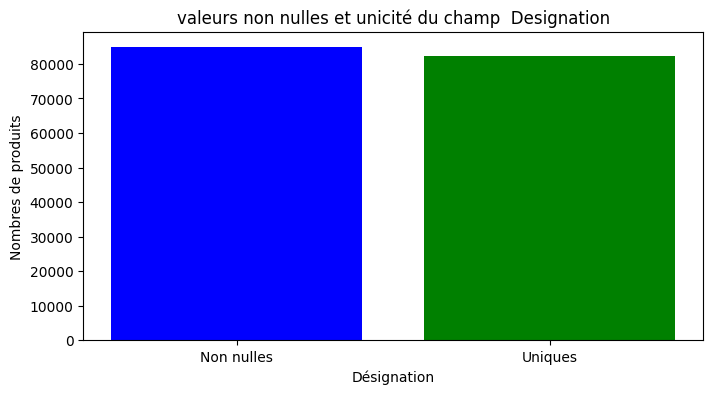

In [60]:
categories = ['Non nulles', 'Uniques']
nb_designation = len(df_feats[~df_feats['designation'].isna()])
nb_designation_u = len(df_feats['designation'].unique())

Nb = [nb_designation, nb_designation_u]

plt.figure(figsize=(8,4))  # Vous pouvez ajuster la taille selon vos besoins
plt.bar(categories,Nb, color=['blue', 'green'])  # Choisir des couleurs

plt.title('valeurs non nulles et unicité du champ  Designation')
plt.xlabel('Désignation')
plt.ylabel('Nombres de produits')
plt.xticks(categories)

plt.show()


## Examinons les valeurs nulles et les doublons du champ 'description'.

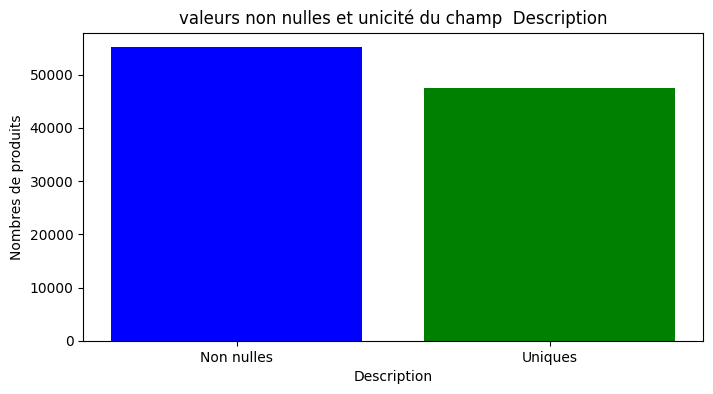

In [61]:
categories = ['Non nulles', 'Uniques']
nb_description = len(df_feats[~df_feats['description'].isna()])
nb_description_u = len(df_feats['description'].unique())

Nb = [nb_description, nb_description_u]

plt.figure(figsize=(8, 4))
plt.bar(categories,Nb, color=['blue', 'green'])

plt.title('valeurs non nulles et unicité du champ  Description')
plt.xlabel('Description')
plt.ylabel('Nombres de produits')
plt.xticks(categories)

plt.show()

## ***4) Récupération du fichier df_langue.csv***

In [63]:
df2=df.copy()
df_langue=pd.read_csv('/content/Rakuten_Text_Classification_ML/df_langue.csv')
df=df2.merge(df_langue.drop(['Unnamed: 0','prdtypecode'], axis=1),on='Id',how='inner')
df['status'] = df['descr_NaN'].apply(lambda x: 'SansDescrip' if x else 'AvecDescrip').astype(str)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84916 entries, 0 to 84915
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              84916 non-null  int64  
 1   designation     84916 non-null  object 
 2   description     55116 non-null  object 
 3   productid       84916 non-null  int64  
 4   imageid         84916 non-null  int64  
 5   prdtypecode     84916 non-null  int64  
 6   PAYS_LANGUE     84916 non-null  object 
 7   RATIO_LANGUE    84916 non-null  float64
 8   ORIGINE_LANGUE  84916 non-null  object 
 9   pays_design     84916 non-null  object 
 10  Ratio_design    84916 non-null  float64
 11  pays_descr      55049 non-null  object 
 12  Ratio_descr     55049 non-null  float64
 13  design_long     84916 non-null  int64  
 14  descrip_long    55049 non-null  float64
 15  descr_NaN       84916 non-null  bool   
 16  status          84916 non-null  object 
dtypes: bool(1), float64(4), int64(5

**Répartition des langues pour la colonne 'designation'**

Index(['fr', 'en', 'de', 'nl', 'ca', 'it', 'ro', 'pt', 'es', 'no'], dtype='object')


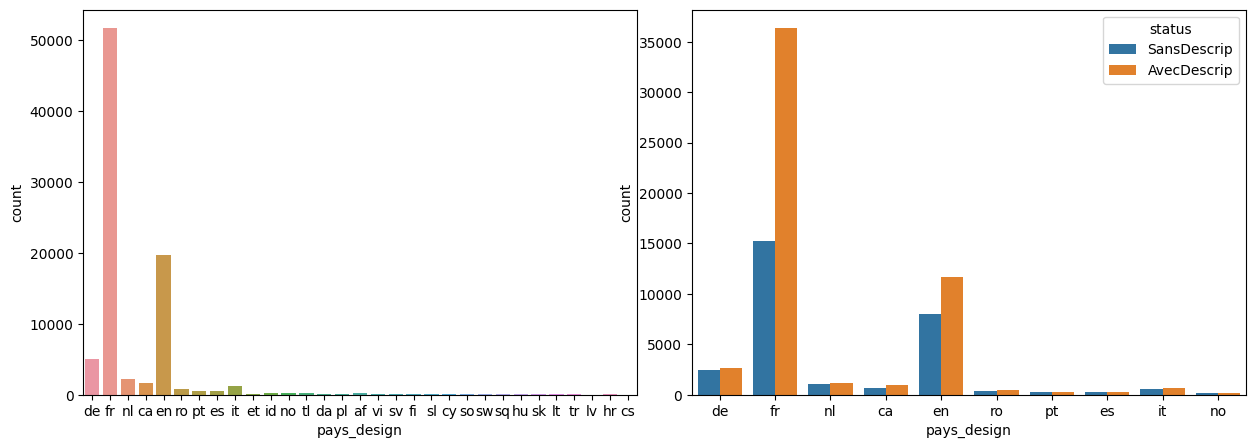

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.countplot(x=df['pays_design'],ax=axs[0])
pays_principaux=df['pays_design'].value_counts()[:10]
print(pays_principaux.index)
sns.countplot(x=df[df['pays_design'].isin(pays_principaux.index)]['pays_design'],hue=df['status'],ax=axs[1])
plt.subplots_adjust( wspace=0.1,hspace=0.5)
plt.show()

**Répartition des langues pour la colonne 'description'**

Index(['fr', 'en', 'de', 'ca', 'it', 'cy', 'pt', 'ro', 'es', 'vi'], dtype='object')


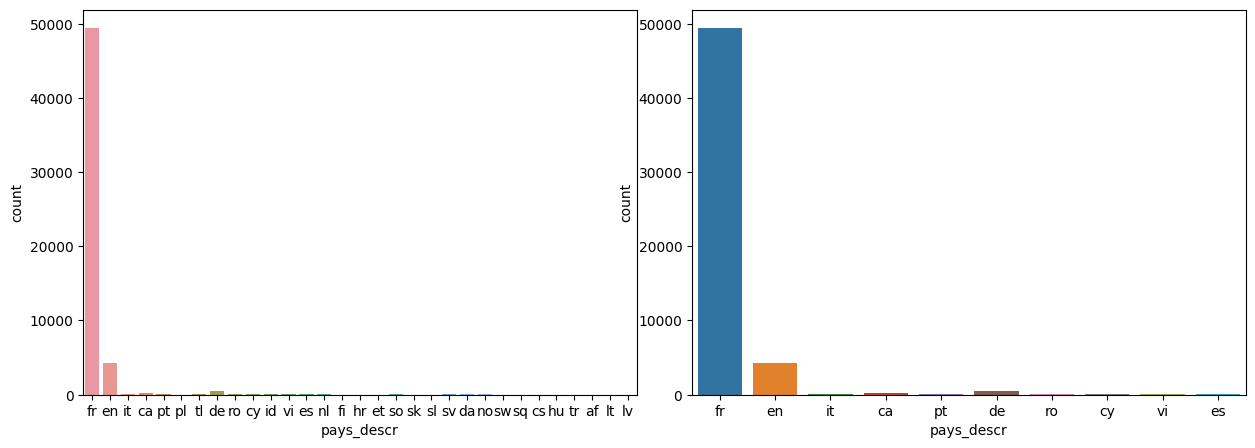

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
df_descrip=df.dropna(subset=['description'])
sns.countplot(x=df_descrip['pays_descr'],ax=axs[0])
pays_principaux=df['pays_descr'].value_counts()[:10]
print(pays_principaux.index)
plt.subplots_adjust( wspace=0.1,hspace=0.5)
sns.countplot(x=df[df['pays_descr'].isin(pays_principaux.index)]['pays_descr'],ax=axs[1])
plt.subplots_adjust( wspace=0.1,hspace=0.5)
plt.show()

**Répartition des langues par catégorie (XX = le reste du monde)**

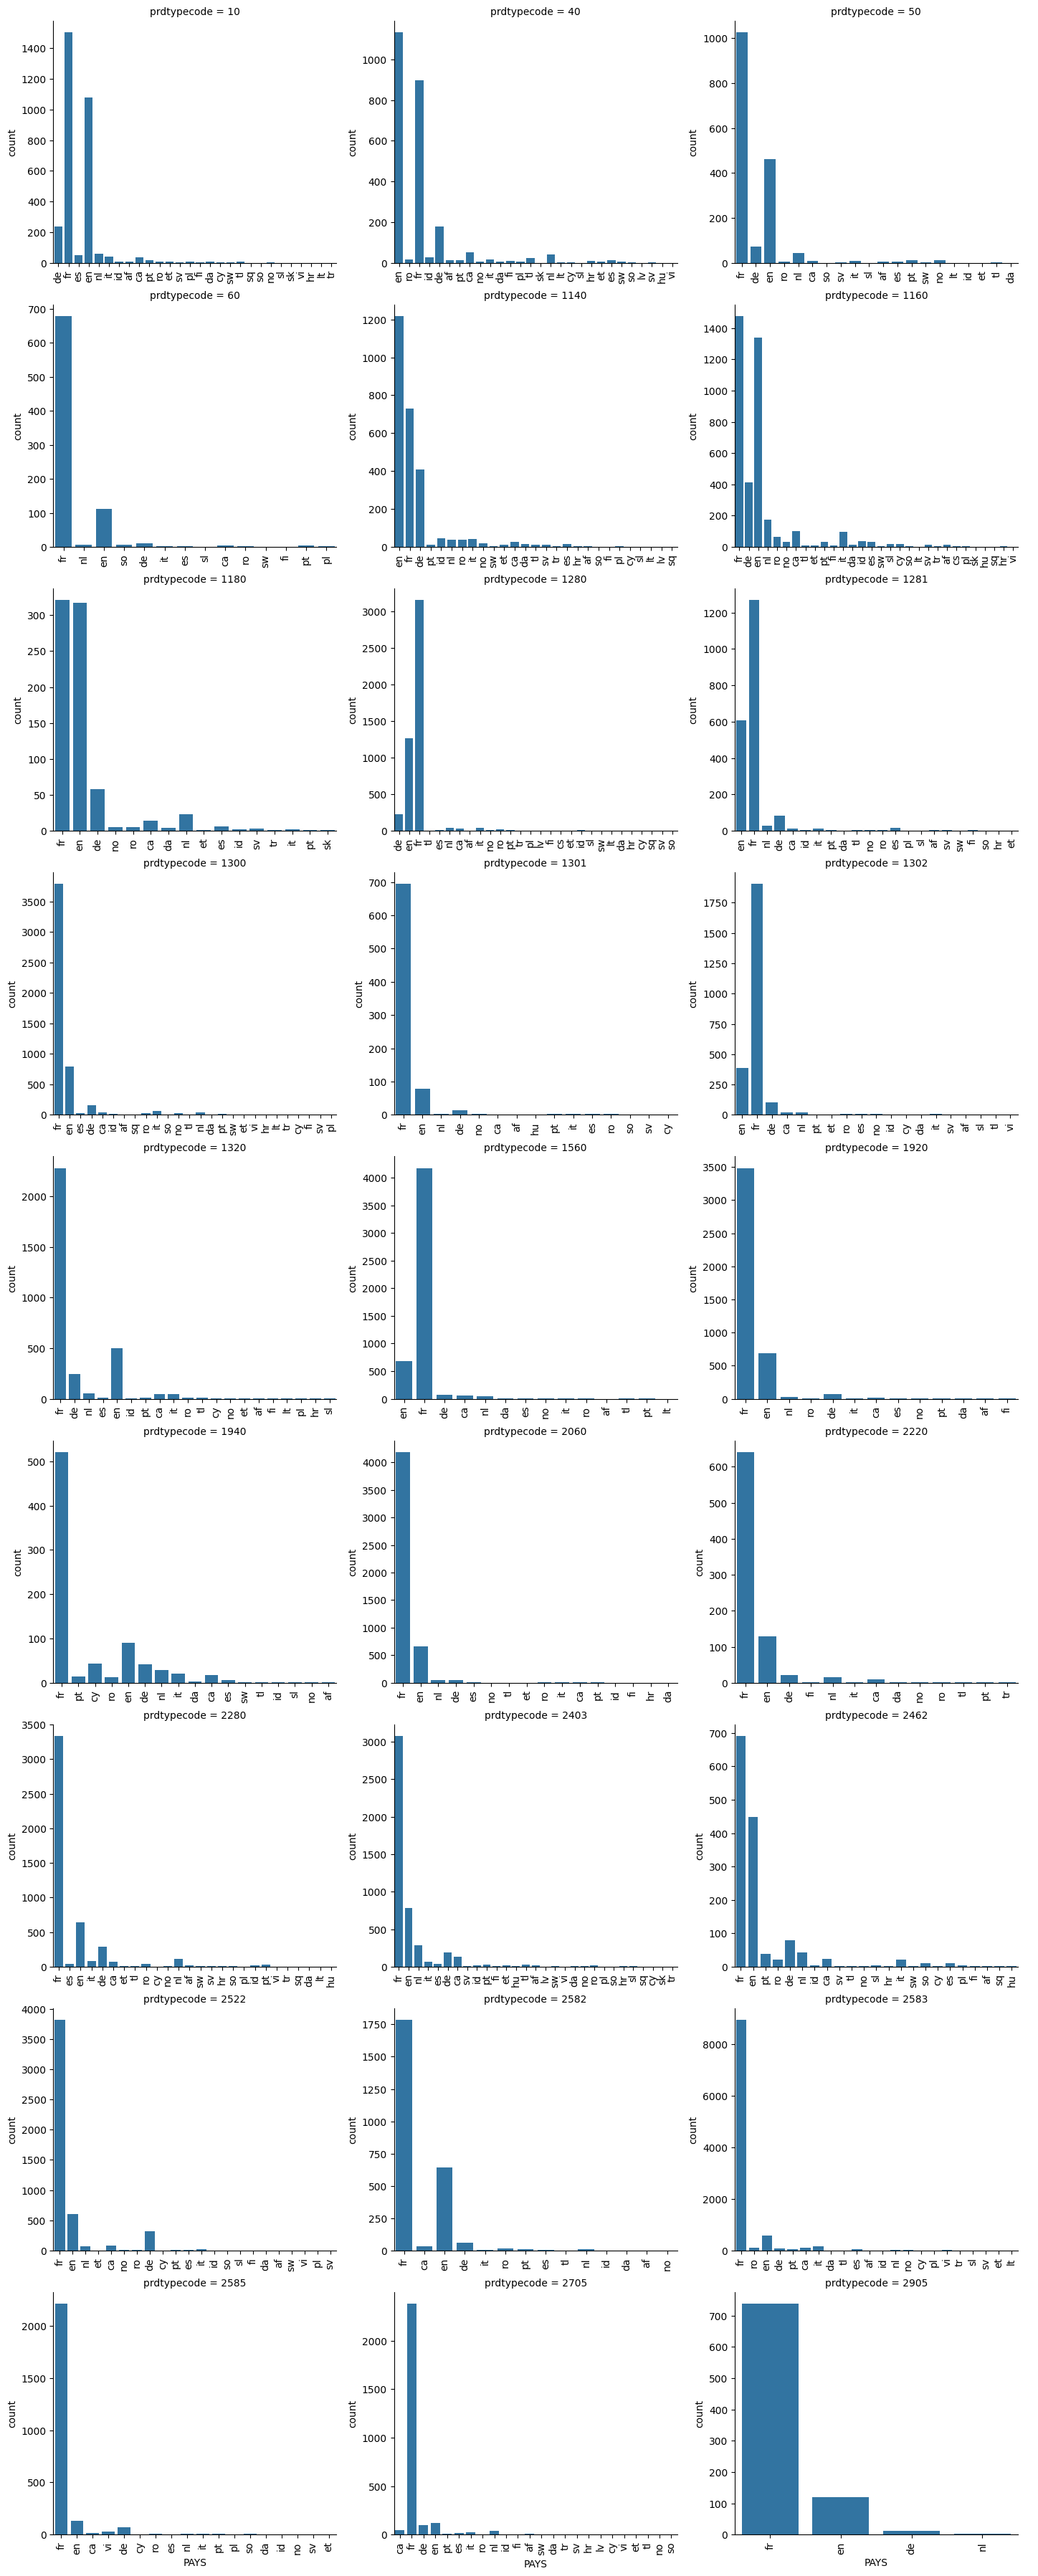

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

# Modifier la taille de la figure ici
g = sns.FacetGrid(data=df, col='prdtypecode', col_wrap=3, sharex=False, sharey=False, height=4, aspect=1.2)
g.map_dataframe(sns.countplot, 'PAYS_LANGUE')
g.set_xticklabels(rotation=90)
g.set_xlabels('PAYS')
g.add_legend()

plt.show()


##***5) Bags of words***

In [78]:
stopwordFR = pd.read_csv("/content/Rakuten_Text_Classification_ML/stopwords_FR_02.csv")
Lcat=df_target.sort_values(by='prdtypecode')['prdtypecode'].unique()


nomenclature=pd.read_csv('/content/Rakuten_Text_Classification_ML/NOMENCLATURE.csv',header=0,encoding='utf-8',sep=';',index_col=0)
catdict=nomenclature.to_dict()['definition']


In [79]:
df_top_40=pd.DataFrame()
vect=CountVectorizer(min_df=4, stop_words=stopwordFR['MOT'].tolist())
TailleCat ={}
for c in Lcat:
    df_cat=df[df['prdtypecode']==c]
    vect=vect.fit(df_cat['designation'])
    TailleCat[c]=len(vect.vocabulary_)
    print("Catégorie : ",c,"   Nombre de mots : ",  TailleCat[c])
    bag_of_words=vect.transform(df_cat['designation'])
    word_occurrences = np.sum(bag_of_words, axis=0)
    words = vect.get_feature_names_out()
    word_occurrences_dict = dict(zip(words, word_occurrences.tolist()[0]))
    top_40_words = sorted(word_occurrences_dict.items(), key=lambda x: x[1], reverse=True)[:40]
    dfout=pd.DataFrame(top_40_words,columns=['mot','occurence'])
    #print(dfout['occurence'].head(40))
    dfout['occurence'] = dfout['occurence'][:-1]
    #print(dfout['occurence'].head(40))
    dfout['occurence'] = dfout['occurence']
    dfout['prdtypecode']=c
    for word, occurrences in top_40_words:
        print(f"{word}: {occurrences}")
    df_top_40=pd.concat([df_top_40,dfout])

Catégorie :  10    Nombre de mots :  843
tome: 154
edition: 127
guide: 84
histoire: 84
france: 60
vie: 55
art: 50
collection: 48
book: 47
journal: 35
life: 35
édition: 35
livre: 34
volume: 34
saint: 33
paris: 32
cours: 28
grand: 27
droit: 26
world: 26
monde: 24
guerre: 23
history: 23
pratique: 23
revue: 23
français: 21
jean: 21
nos: 21
science: 21
temps: 21
ans: 20
cd: 20
siècle: 20
pays: 19
homme: 18
oeuvres: 18
vol: 18
100: 17
europe: 17
lettres: 17
Catégorie :  40    Nombre de mots :  759
import: 584
jeu: 384
magideal: 282
pc: 235
allemand: 226
edition: 194
japonais: 166
xbox: 109
version: 106
nintendo: 100
anglais: 81
complet: 78
jap: 77
jeux: 73
360: 70
ensemble: 70
japon: 64
câble: 62
ds: 62
playstation: 61
ps4: 61
game: 58
collection: 53
wii: 53
console: 51
contrôleur: 50
ps3: 50
audio: 49
one: 47
super: 47
world: 47
sony: 46
protection: 44
collector: 42
us: 42
pack: 40
adaptateur: 38
ii: 38
manette: 36
uk: 36
Catégorie :  50    Nombre de mots :  624
nintendo: 356
jeu: 336
manet

**Matrice de semblarité (Pourcentage de mots en commun (parmi les 40 premiers))**

In [80]:
MAT=pd.DataFrame(np.zeros((len(Lcat),len(Lcat))) ,index=Lcat, columns=Lcat)

for c1 in Lcat:
    df1=df_top_40[df_top_40['prdtypecode']==c1]
    res1=[x for x in (df1.mot) ]
    for c2 in Lcat:
        df2=df_top_40[df_top_40['prdtypecode']==c2]
        res2=[x for x in (df2.mot) ]
        res=[x for x in res1 if x  in res2]
        #print(c1,c2,res)
        MAT.loc[c1,c2]=len(res)/40*100

<Axes: >

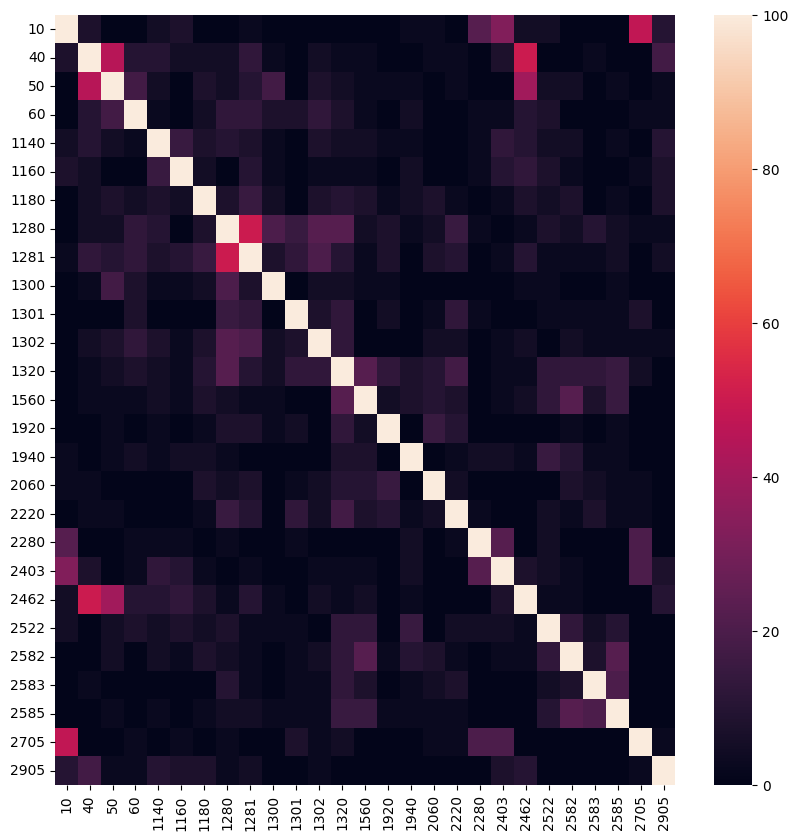

In [81]:
plt.figure(figsize=(10,10))
sns.heatmap(MAT)

**Nous pouvons déjà distinguer des catégories qui risquent de poser des problémes** :   

**les catégories 40,50 et 2462**
1.   40: 'jeux video pour pc et consoles'
2.   50: ' accesoires jeux video'
3.   2462: 'consoles de jeux video et jeux videos'
**les catégories 1280 et 1281**
1.   1280: 'jouets, peluches, puppets',
2.   1281: 'jeux de societe/cartes',
**les catégories 10, 2280, 2403 et 2705**
1.   10: 'livres'
2.   2280: 'magazines'
3.   2403: 'livres et bds'
4.   2705: 'bds et livres'

##***Nuages de mots***  
***Liste des 40 mots les plus fréquents par categorie***

In [82]:

vect=CountVectorizer(min_df=4, stop_words=stopwordFR['MOT'].tolist())
TailleCat ={}
for c in Lcat:
    df_cat=df[df['prdtypecode']==c]
    vect=vect.fit(df_cat['designation'])
    TailleCat[c]=len(vect.vocabulary_)
    print("Catégorie : ",c,"   Nombre de mots : ",  TailleCat[c],"  Nombre de produits ",len(df_cat))
    bag_of_words=vect.transform(df_cat['designation'])
    word_occurrences = np.sum(bag_of_words, axis=0)
    words = vect.get_feature_names_out()
    word_occurrences_dict = dict(zip(words, word_occurrences.tolist()[0]))
    top_40_words = sorted(word_occurrences_dict.items(), key=lambda x: x[1], reverse=True)[:40]
    dfout=pd.DataFrame(top_40_words,columns=['mot','occurence'])
    dfout['prdtypecode']=c
    for word, occurrences in top_40_words:
        print(f"{word}: {occurrences}")
    df_top_40=pd.concat([df_top_40,dfout])

Catégorie :  10    Nombre de mots :  843   Nombre de produits  3116
tome: 154
edition: 127
guide: 84
histoire: 84
france: 60
vie: 55
art: 50
collection: 48
book: 47
journal: 35
life: 35
édition: 35
livre: 34
volume: 34
saint: 33
paris: 32
cours: 28
grand: 27
droit: 26
world: 26
monde: 24
guerre: 23
history: 23
pratique: 23
revue: 23
français: 21
jean: 21
nos: 21
science: 21
temps: 21
ans: 20
cd: 20
siècle: 20
pays: 19
homme: 18
oeuvres: 18
vol: 18
100: 17
europe: 17
lettres: 17
Catégorie :  40    Nombre de mots :  759   Nombre de produits  2508
import: 584
jeu: 384
magideal: 282
pc: 235
allemand: 226
edition: 194
japonais: 166
xbox: 109
version: 106
nintendo: 100
anglais: 81
complet: 78
jap: 77
jeux: 73
360: 70
ensemble: 70
japon: 64
câble: 62
ds: 62
playstation: 61
ps4: 61
game: 58
collection: 53
wii: 53
console: 51
contrôleur: 50
ps3: 50
audio: 49
one: 47
super: 47
world: 47
sony: 46
protection: 44
collector: 42
us: 42
pack: 40
adaptateur: 38
ii: 38
manette: 36
uk: 36
Catégorie :  50

In [83]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

# Définir le calque du nuage des mots
wc = WordCloud(background_color="black", max_words=100, stopwords=stopwordFR['MOT'].tolist(), max_font_size=50, random_state=42)

In [84]:
df_top_40.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2160 entries, 0 to 39
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   mot          2160 non-null   object 
 1   occurence    2133 non-null   float64
 2   prdtypecode  2160 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 67.5+ KB


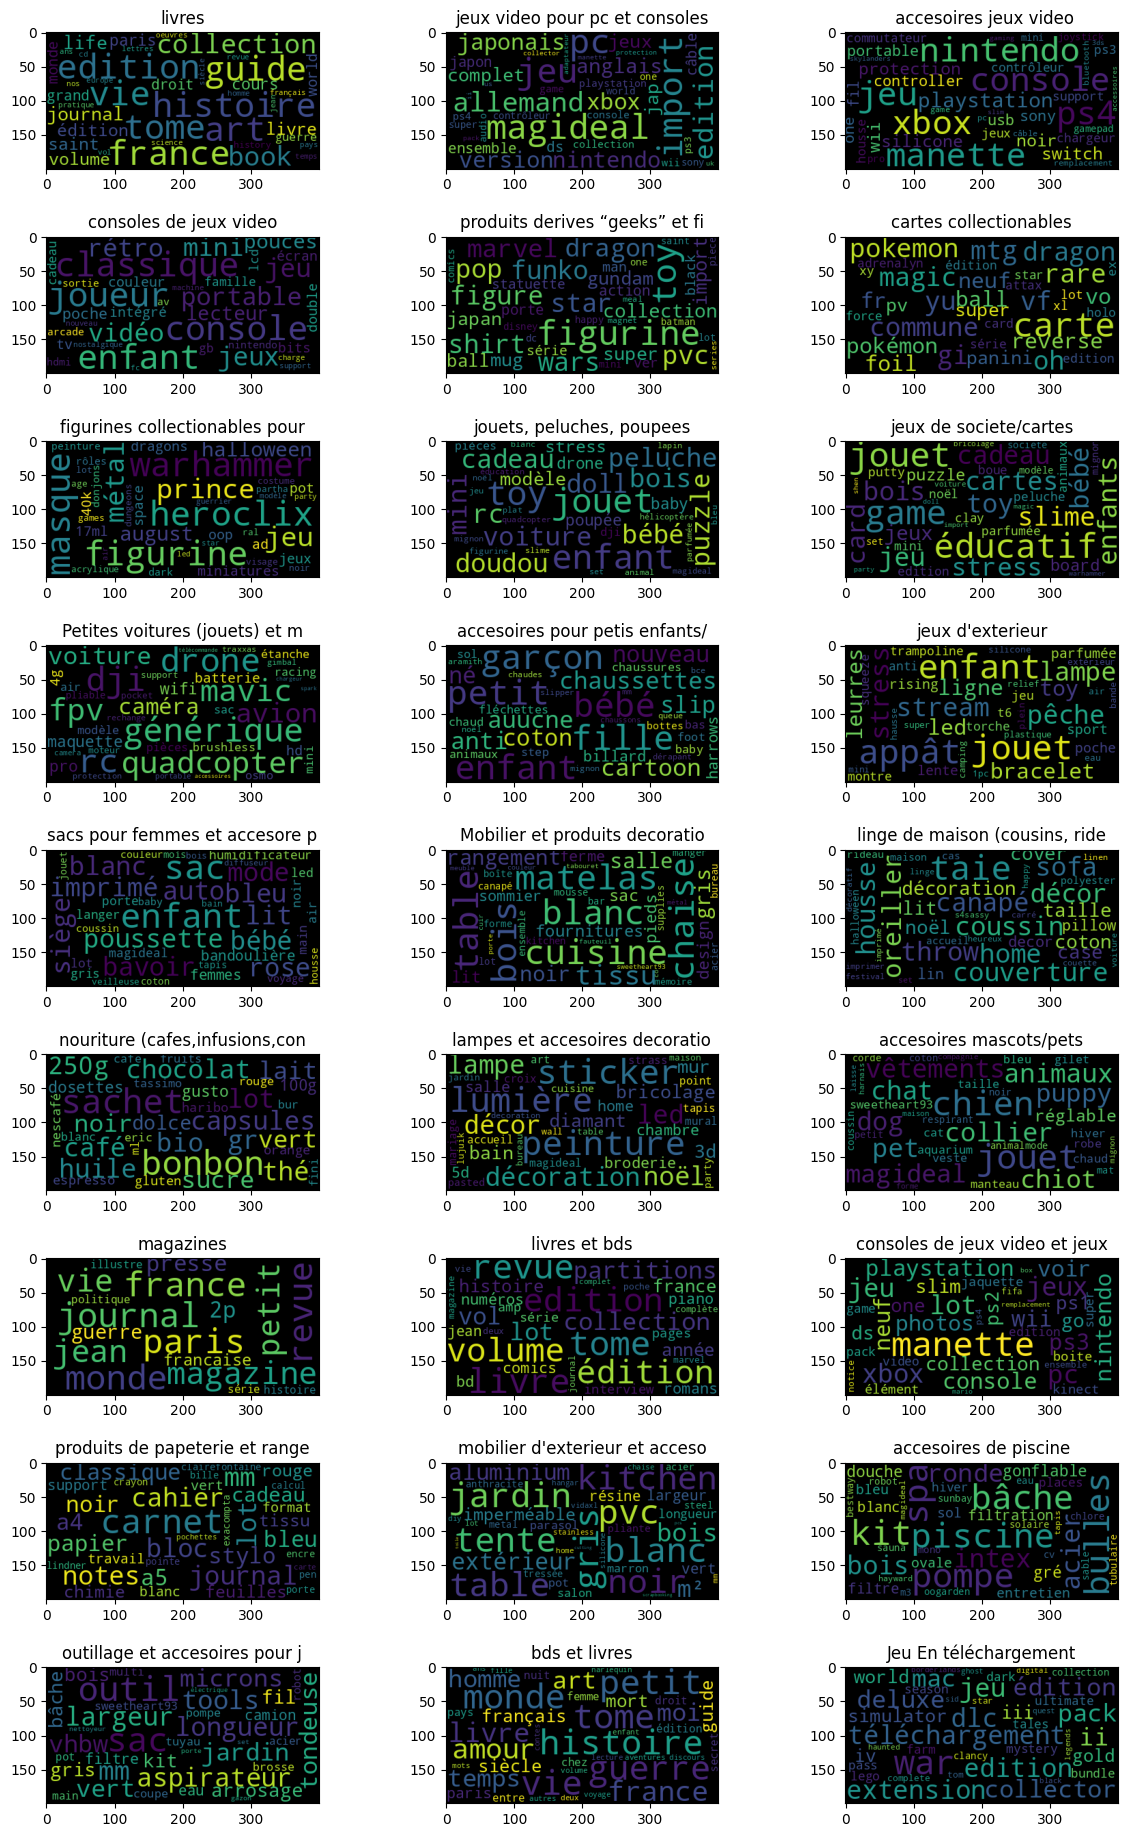

In [86]:
fig, axs = plt.subplots(9, 3, figsize=(15,23))
for c,ax in zip(Lcat,axs.flat):
    #print(c)
    df_cat=df_top_40[df_top_40['prdtypecode']==c]
    # Définir la variable text
    text = ""
    for mot in df_cat['mot'] :
        text += mot + " "
    #print(c,"Catégorie ",catdict[c] )
    wc.generate(text)           # "Calcul" du wordcloud
    ax.imshow(wc) # Affichage
    ax.set_title( catdict[c][:30])
plt.subplots_adjust( wspace=0.1,hspace=0.5)
plt.show()
